# Camera calibration

Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration4.jpg
Chessboard corner detection failed: ../CarND-Advanced-Lane-Lines/camera_cal/calibration5.jpg


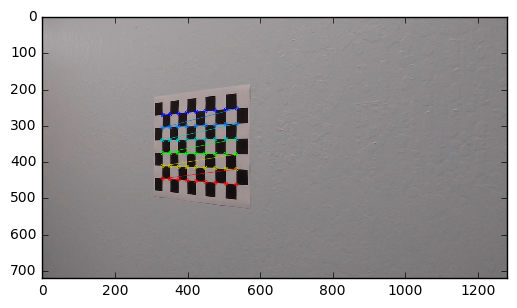

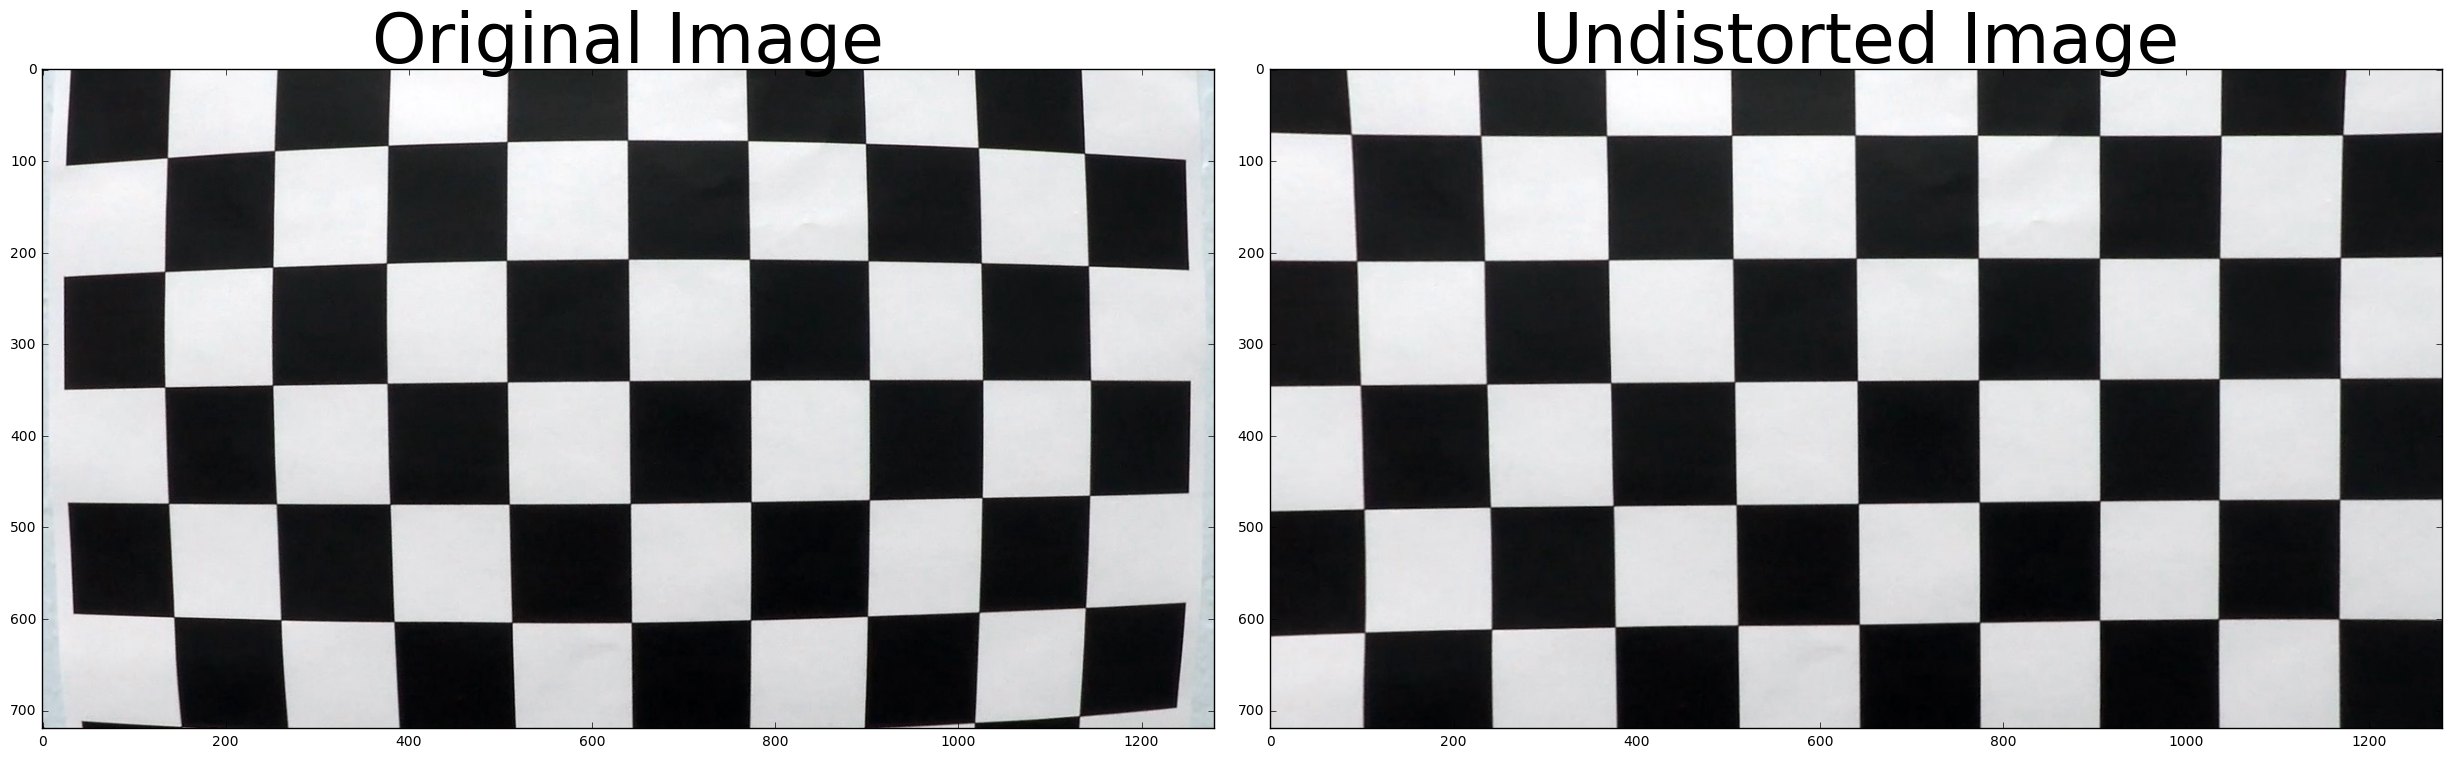

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Arrange array of test images, and pick a test image
calibration_images_filenames = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg'
show_corners_image_filename = '../CarND-Advanced-Lane-Lines/camera_cal/calibration7.jpg'
calibration_images_filenames.remove(test_image_filename)

inside_corners_count_x = 9
inside_corners_count_y = 6

objp = np.zeros((inside_corners_count_x * inside_corners_count_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:inside_corners_count_x, 0:inside_corners_count_y].T.reshape(-1,2)

corners_res = []
objp_res = []

detection_failed_count = 0

# Search for chessboard corners for every image
for calibration_image_filename in calibration_images_filenames:
    img = cv2.imread(calibration_image_filename)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find chhessboard corners
    ret, corners = cv2.findChessboardCorners(gray_img, (inside_corners_count_x, inside_corners_count_y), None)
    
    if ret:
        corners_res.append(corners)
        objp_res.append(objp)
    else:
        print('Chessboard corner detection failed:', calibration_image_filename)
    
    # This is used for debugging - demonstrate found corners on screen
    if show_corners_image_filename == calibration_image_filename:
        img_corners = cv2.drawChessboardCorners(img, (inside_corners_count_x, inside_corners_count_y), corners, ret)
        plt.imshow(img_corners)

test_img = cv2.imread(test_image_filename)

# Calibrate camera on information collected from chessboard corners images
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp_res, corners_res, test_img.shape[0:2], None, None)

def undistort(image):
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    return undistorted_img

undistorted_img = undistort(test_img)

# Draw original and undistorted images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Binary Image

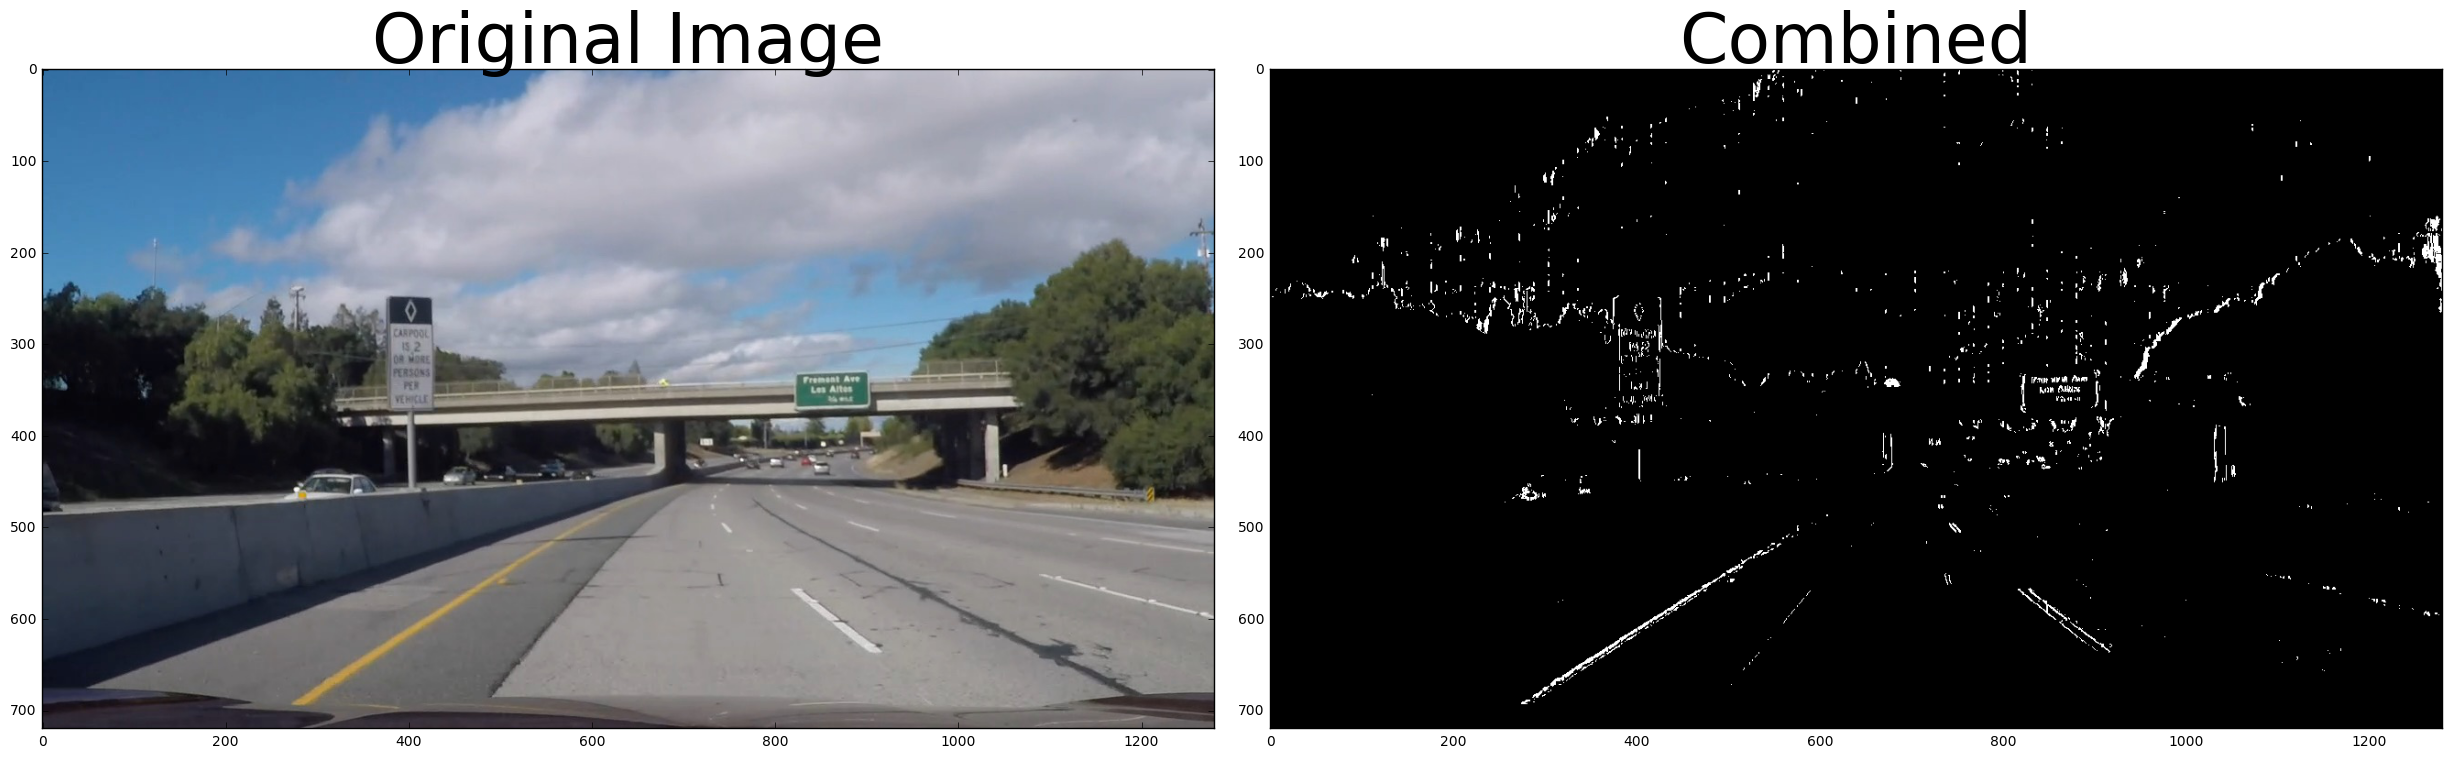

In [2]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return sxbinary

# Retuns binary image based on thresholding functions
def get_binary_image(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    light_mask = np.zeros_like(L)
    light_mask[(S >= 5) & (L >= 130)] = 1

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx_l = abs_sobel_thresh(L, orient='x', sobel_kernel=ksize, thresh=(25, 100))
    gradx_s = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(10, 100))
    
    combined = np.zeros_like(gradx_s)
    # For some images S channel works better, while for others L channel does
    # Mix results from either channels
    combined[((gradx_l == 1) | (gradx_s == 1)) & (light_mask == 1)] = 1
    
    return combined

# Read in an image
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/binarize_test/test5.jpg')

# Obtain binary image
combined = get_binary_image(raw_test_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(raw_test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective transform

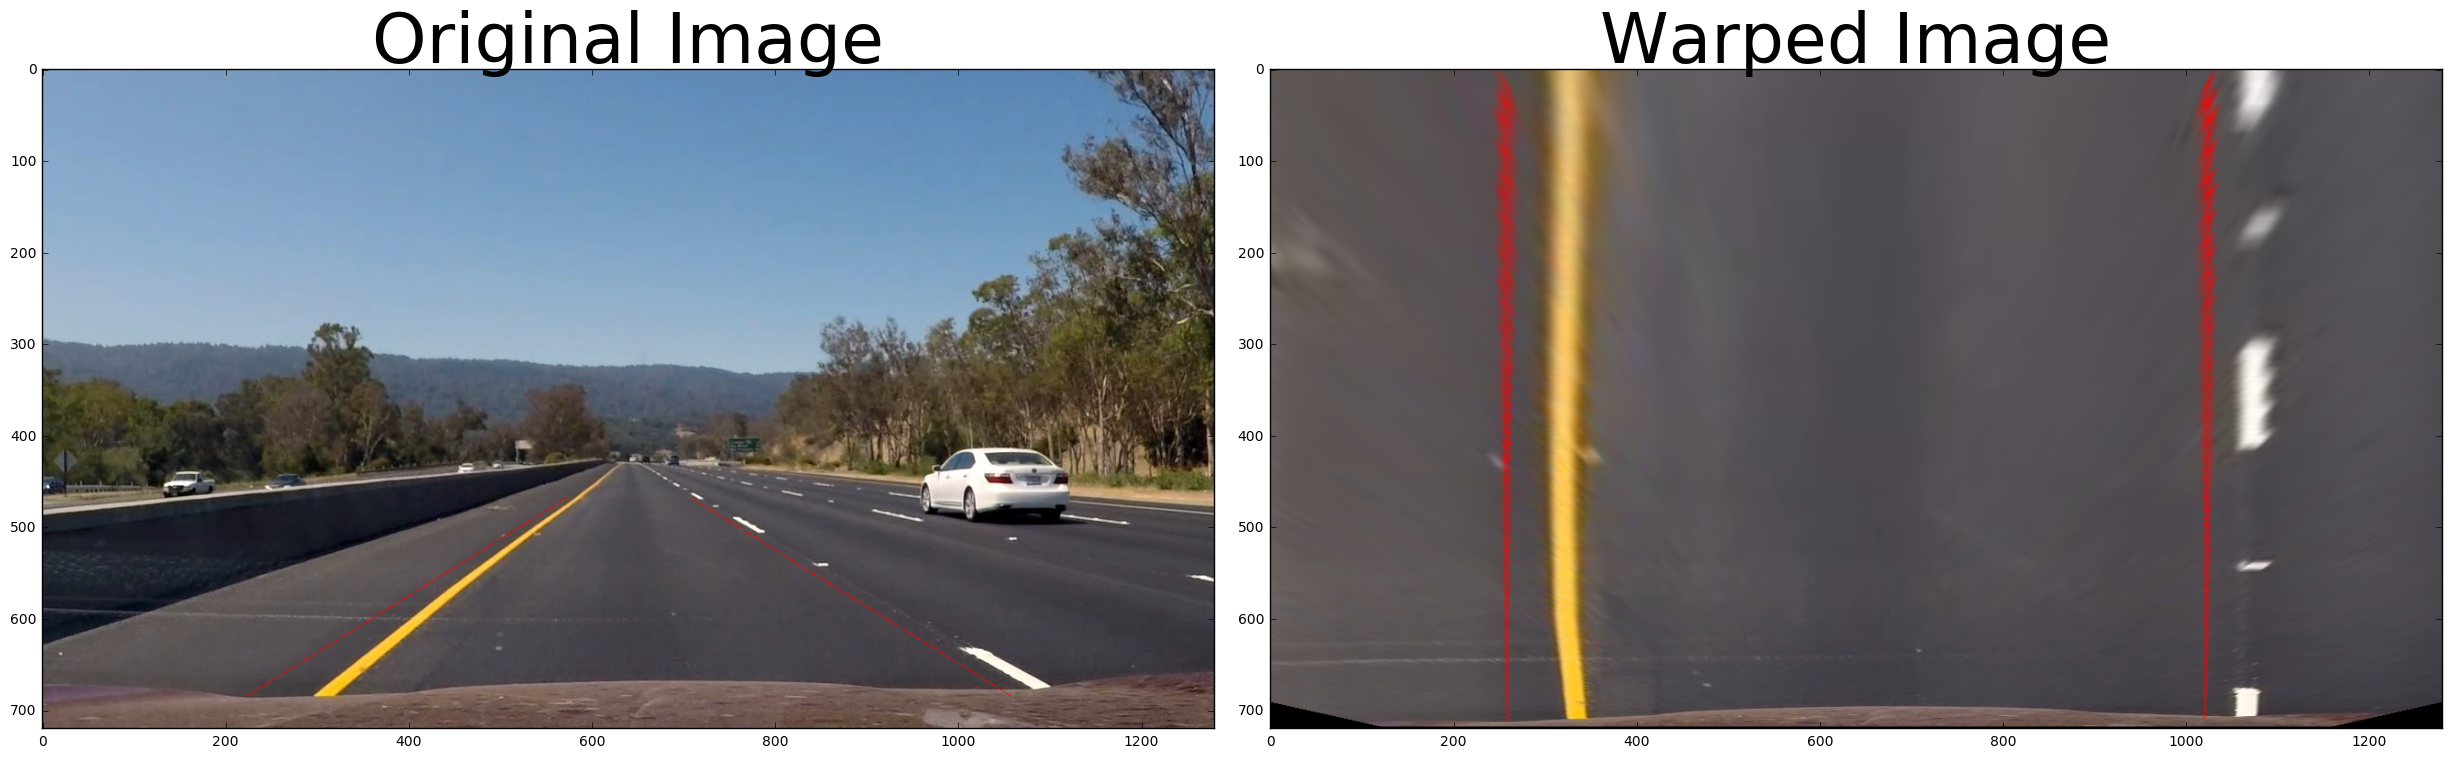

In [4]:
# Transforms image to a bird eye view
def change_perspective(image, reverse = False):
    image_width = image.shape[1]
    image_height = image.shape[0]
    
    # Source coordinates
    src = np.float32([
            [image_width * 0.4475, image_height * 0.65],
            [image_width * 0.5525, image_height * 0.65],
            [image_width * 0.175, image_height * 0.95],
            [image_width * 0.825, image_height * 0.95],
        ])
    
    # Destination coordinates
    dst = np.float32([
            [image_width * 0.2, image_height * 0.025],
            [image_width * 0.8, image_height * 0.025],
            [image_width * 0.2, image_height * 0.975],
            [image_width * 0.8, image_height * 0.975],
        ])
    
    if (reverse):
        src, dst = dst, src

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

    return warped

test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/perspective_test.jpg')

image_width = test_image.shape[1]
image_height = test_image.shape[0]

# Let's draw lines on source coordinates to visually confirm they are parallel in the destination image
cv2.line(test_image, \
         (573, 468), \
         (224, 684), \
         (255, 0, 0))
cv2.line(test_image, \
         (707, 468), \
         (1056, 684), \
         (255, 0, 0))

undistorted_img = undistort(test_image)

combined = get_binary_image(undistorted_img)

warped = change_perspective(undistorted_img)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Finding the lanes

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Curvature: 253.6m, Center offset: 0.1m


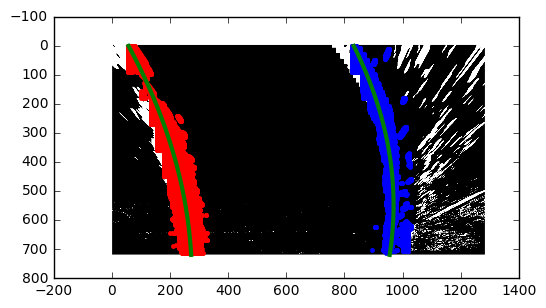

In [5]:
from scipy import signal
import itertools

# Obtains pixel coordinates of non-zero pixels near a given X of an image
def get_points_around_x(image, lane_x, low_y, image_width):
    image_width = image.shape[1]
    # Assume this is a distance at which we will search for non-zero pixels
    sub_piece_diff = image_width * 0.05
    
    low_x = max(0, lane_x - sub_piece_diff)
    high_x = min(image_width, lane_x + sub_piece_diff)
    
    # Cut a portion of an image where we will search for non-zero pixels
    sub_piece = image[:, low_x:high_x]
    coordinates = np.nonzero(sub_piece)
    coordinates = [coordinates[0] + low_y, coordinates[1] + low_x]
        
    return coordinates

# Obtains peaks from a given portion of an image
def get_peaks(image):
    image_width = image.shape[1]
    histogram = np.sum(image, axis=0)
    
    peak_indexes = signal.find_peaks_cwt(histogram, np.arange(image_width * 0.025, image_width * 0.05))
    
    return peak_indexes, histogram

# Sorts peaks from one that has most points in it to the one that has least points in it
def sorted_peaks(image):
    peak_indexes, histogram = get_peaks(image)
    
    peak_values = [histogram[index] for index in peak_indexes]
    peak_indexes_sorted = [indexes for (values, indexes) in sorted(zip(peak_values, peak_indexes), reverse = True)]
    
    return peak_indexes_sorted

# Determines if given polynomial fit represents a good lane
def is_good_fit(fit, weighted_residual = 0, image_width = 1):
    scaled_residual = weighted_residual / image_width
    # Makre sure we don't have too much residual and we don't bend too much
    return fit != None and abs(fit[0]) < 0.001 and scaled_residual < 1

# Make sure that given points are on the right distance for a lanes
def is_good_lanes(lanes, image_width, piece_ratio):
    # Assume these are the ranges of distances for legitimate lanes
    base_distance = 0.57 * image_width
    # The "higher" the piece is, the more variation can happen due to tilt
    variation = 0.1 * image_width + (1 - piece_ratio) * 0.2 * image_width
    min_distance = base_distance - variation
    max_distance = base_distance + variation
    
    distance = abs(lanes[0] - lanes[1])
        
    return distance >= min_distance and distance <= max_distance

# Verifies how given lane fits match
def is_good_lane_fits(left_fit, right_fit, image_width, image_height):
    # Obtain a few points to probe the fit
    y_vals = [0, image_height // 2, max(0, image_height - 1)]
    left_fit_x = get_x_for_line(left_fit, y_vals)
    right_fit_x = get_x_for_line(right_fit, y_vals)
    
    max_y_val = max(y_vals)
        
    result = True
    # Probe each point
    for i, y_val in enumerate(y_vals):
        lanes = [left_fit_x[i], right_fit_x[i]]
        # Make sure that distance between lanes at given point is acceptable
        if not is_good_lanes(lanes, image_width, y_val / max_y_val):
            result = False
            break
    
    # Make sure that lane bend is acceptable and we are not overfitting
    if result:
        result = abs(abs(left_fit[0]) - abs(right_fit[0])) < 0.0004
    
    return result

# Returns set of lane candidates given set of peaks
def get_lanes_candidates(peaks, image_width, piece_ratio):
    # Only consider 5 highest peaks
    peaks = peaks[0:5]
        
    # Obtain all combination of peaks indexes that might represent left and right lane
    lane_ind = list(itertools.combinations(range(0, len(peaks)), 2))
    sum_squares = lambda arr: sum([x ** 2 for x in arr])
    # Sort those peaks, so that more likely lane pairs are in the begining of an array. Use sum sqares as a key.
    # Note: We don't actually have to compute it every time, can be optimized
    sort_lane_ind = sorted(lane_ind, key=sum_squares)
    # All pairs of peaks that might be lane coordinates
    lanes_candidates = [(peaks[peak_indexes[0]], peaks[peak_indexes[1]])  for peak_indexes in sort_lane_ind]
    
    # List of good lane choices
    lanes_good = []
    
    # Iterate lane candidates
    for index, lanes in enumerate(lanes_candidates):
        # Check if distance for those 2 peaks is about right
        if is_good_lanes(lanes, image_width, piece_ratio):
            sorted_lanes = lanes
            sorted_lanes_ind = sort_lane_ind[index]
            if lanes[0] > lanes[1]:
                sorted_lanes = [sorted_lanes[1], sorted_lanes[0]]
                sorted_lanes_ind = [sorted_lanes_ind[1], sorted_lanes_ind[0]]
            
            # If distance is right, this is a good candidate
            lanes_good.append(sorted_lanes)
            
    return lanes_good

# Obtains portion of an image that represents a horizontal cut of an image with given index\count
def get_piece(image, piece_index, piece_height):
    low_y = piece_height * piece_index
    high_y = piece_height * (piece_index + 1)

    piece = image[low_y:high_y, :]
    
    return piece

# Checks if given pixels make a good lanes. Does it by applying some heuristics on what good lane should look like.
def is_good_points(left_lane_coordinates, \
                   right_lane_coordinates, \
                   image_width, \
                   image_height):
    if (len(left_lane_coordinates[0]) == 0 or len(right_lane_coordinates[0]) == 0):
        return False
    
    left_fit, left_residual = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    right_fit, right_residual = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
    
    # Make sure we have good fits
    left_fit_good = is_good_fit(left_fit, left_residual // len(left_lane_coordinates[0]), image_width)
    right_fit_good = is_good_fit(right_fit, right_residual // len(right_lane_coordinates[0]), image_width)
    # And those fits match together good as well
    both_fit_match = is_good_lane_fits(left_fit, right_fit, image_width, image_height)
                
    return left_fit_good and right_fit_good and both_fit_match

# Returns score based on on how much residual polynomial fit have returned
def score_lanes_residual(left_lane_coordinates, right_lane_coordinates):
    _, left_residual = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    _, right_residual = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
    
    normalized_left_residual = left_residual / len(left_lane_coordinates[0])
    normalized_right_residual = right_residual / len(right_lane_coordinates[0])
    
    # I have chosen to return sum of squares of residuals to penalize outliers more 
    return (normalized_left_residual ** 2) + (normalized_right_residual ** 2)

# Returns slope and bend of each lane given list of it's coordinates
def score_lanes_bend_and_slope(left_lane_coordinates, right_lane_coordinates):
    left_fit, _ = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    right_fit, _ = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
                                                      
    return abs(left_fit[0] - right_fit[0]), abs(left_fit[1] - right_fit[1])

# The greater the score. Lower score means better lanes.
def score_lanes(left_lane_coordinates, right_lane_coordinates):
    # Empty lanes get bad score
    if (len(left_lane_coordinates[1]) == 0 or \
        len(left_lane_coordinates[0]) == 0 or \
        len(right_lane_coordinates[1]) == 0 or \
        len(right_lane_coordinates[0]) == 0):
        return 10**14
    
    bend_sclaer = 5*10**9
    slope_scaler = 4*10**7
    count_scaler = 10**12
    
    # First factor is how well polynomial fits the lanes
    score_residual = score_lanes_residual(left_lane_coordinates, right_lane_coordinates)
    # Second factor is how well matched are slopes and bends of the lane
    score_bend, score_slope = score_lanes_bend_and_slope(left_lane_coordinates, right_lane_coordinates)
    score_bend *= bend_sclaer
    score_slope *= slope_scaler
    # Third factor is how many points are there in the lane. I assume that better lane has more pixels then noise.
    score_count = count_scaler / (len(left_lane_coordinates[0]) + len(right_lane_coordinates[0]))
    
    # Perform score fusion and obtain resulting score
    score = score_residual + score_bend + score_slope + score_count
    return score

# Returns lane pixels given image and previous lane pixels (if available)
def get_lane_points(image, left_lane_coordinates = None, right_lane_coordinates = None, fail_count = 0):
    max_failures = 10
    
    image_width = image.shape[1]
    image_height = image.shape[0]
    
    # If we don't have any previous results, perform full search
    if left_lane_coordinates == None or right_lane_coordinates == None:
        left_points, right_points, good_points = get_lane_points_bottom_up(image)
        if not good_points:
            fail_count += 1
        else:
            fail_count = 0
        return left_points, right_points, fail_count
    
    else:
        # If we do have previous lanes findings, try to find lanes nearby
        left_points, right_points = get_lane_points_nearby(image, left_lane_coordinates, right_lane_coordinates)
        # If what we found nearby are a good scoring lanes, keep them
        if is_good_points(left_points, right_points, image_width, image_height):
            return left_points, right_points, 0
        else:
            # If we have relatively few failres, return found points
            if fail_count < max_failures:
                return left_points, right_points, fail_count + 1
            
            # Otehrwise perform the full search
            left_points, right_points, good_points = get_lane_points_bottom_up(image)
            if not good_points:
                # We had failures before, and failed again. Keep trying.
                fail_count = max_failures
            else:
                fail_count = 0
            return left_points, right_points, fail_count

# Searches for lanes near the previous lanes pick
def get_lane_points_nearby(image, left_lane_coordinates, right_lane_coordinates):
    pieces_desired = 8
    image_height = image.shape[0]
    image_width = image.shape[1]
    piece_height = image_height // pieces_desired
    
    # Perform polynomial fit for the previous set of lanes
    left_fit, _ = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    right_fit, _ = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
    
    new_left_lane_coordinates = [[],[]]
    new_right_lane_coordinates = [[],[]]
    
    # For each part of an image
    for piece_index in reversed(range(0, pieces_desired)):
        low_y = piece_height * piece_index
        high_y = piece_height * (piece_index + 1)
        mid_y = np.mean([low_y, high_y])
        
        # Determine the point where lane used to be last time
        expected_left_x = get_x_for_line(left_fit, mid_y)
        expected_right_x = get_x_for_line(right_fit, mid_y)

        piece = image[low_y:high_y, :]
         
        # Try to find lane pixels near where lane used to be in the last frame
        coordinates = get_points_around_x(piece, expected_left_x, low_y, image_width)
        new_left_lane_coordinates[0].extend(coordinates[0])
        new_left_lane_coordinates[1].extend(coordinates[1])
            
        coordinates = get_points_around_x(piece, expected_right_x, low_y, image_width)
        new_right_lane_coordinates[0].extend(coordinates[0])
        new_right_lane_coordinates[1].extend(coordinates[1])
    
    # Return new lane pixels
    new_left_lane_coordinates = np.array(new_left_lane_coordinates)
    new_right_lane_coordinates = np.array(new_right_lane_coordinates)
        
    return new_left_lane_coordinates, new_right_lane_coordinates

# Finds lane pieces by searching from the bottom of the image based on peaks found
def get_lane_points_bottom_up(image):
    pieces_desired = 8
    image_height = image.shape[0]
    image_width = image.shape[1]
    piece_height = image_height // pieces_desired
    starter_piece_count = 6
    
    # Find peaks and lane candidates for the bottom quarter of an image
    init_piece = get_piece(image, pieces_desired / 2 - 1, piece_height * 2)
    init_peaks = sorted_peaks(init_piece)
    init_lane_cand  = get_lanes_candidates(init_peaks, image_width, 0)
    
    # We will try to find best lanes to use them in case of failure
    best_score = None
    best_image_coordinates_left = [[],[]]
    best_image_coordinates_right = [[],[]]
    
    # Try every lane candidate points
    for candidate in init_lane_cand:
        image_coordinates_left = [[],[]]
        image_coordinates_right = [[],[]]
        
        current_candidate = candidate
        
        # Split image in 8 smaller images horizontally
        for piece_index in reversed(range(0, pieces_desired)):            
            low_y = piece_height * piece_index

            piece = get_piece(image, piece_index, piece_height)
            
            next_candidate = [current_candidate[0], current_candidate[1]]

            # Try finding lane points for the current candidate
            if current_candidate[0] != None:
                coordinates_left = get_points_around_x(piece, current_candidate[0], low_y, image_width)
                image_coordinates_left[0].extend(coordinates_left[0])
                image_coordinates_left[1].extend(coordinates_left[1])
                
                if len(coordinates_left[1]) > 0:
                    next_candidate[0] = np.mean(coordinates_left[1])

            if current_candidate[1] != None:
                coordinates_right = get_points_around_x(piece, current_candidate[1], low_y, image_width)
                image_coordinates_right[0].extend(coordinates_right[0])
                image_coordinates_right[1].extend(coordinates_right[1])
                
                if len(coordinates_right[1]) > 0:
                    next_candidate[1] = np.mean(coordinates_right[1])
                
            current_candidate = next_candidate
        
        # If we found good lanes, return
        if is_good_points(image_coordinates_left, image_coordinates_right, image_width, image_height):
            return np.array(image_coordinates_left), np.array(image_coordinates_right), True
        
        # Otherwise, track best score we saw, and best coordinates we saw according to that score
        current_score = score_lanes(image_coordinates_left, image_coordinates_right)
        if best_score == None or current_score < best_score:
            best_score = current_score
            best_image_coordinates_left = image_coordinates_left
            best_image_coordinates_right = image_coordinates_right
    
    # This is the failure case. If everything else failed, return best lanes we saw.
    return np.array(best_image_coordinates_left), np.array(best_image_coordinates_right), False

# Performs polynomial fit for the given points. Returns polynomial fit and residual.
def fit_line(line_x, line_y, order_polynomial = 2):
    fit, residual, _, _, _ = np.polyfit(line_y, line_x, order_polynomial, full = True)
    return fit, residual

# Evaluates polynomial and finds value at given point
def get_x_for_line(line_fit, line_y):
    poly = np.poly1d(line_fit)
    return poly(line_y)

# Calculates curvature given lane polynomial fit and bottom vertical point
def get_curvature(line_fit, y_eval):
    return ((1 + (2 * line_fit[0] * y_eval + line_fit[1]) ** 2) ** 1.5) \
                             / np.absolute(2 * line_fit[0])

# Calculates curvature and distance from center, in meters
def get_curvature_and_distance_from_center(left_lane_coordinates, right_lane_coordinates, image_width, image_height):
    # Define conversions in x and y from pixels space to meters
    lane_width_pix = image_width * 0.57
    ym_per_pix = 23 / image_height # meters per pixel in y dimension
    xm_per_pix = 3.7 / lane_width_pix # meteres per pixel in x dimension
    
    # Find lanes fit in in meters
    left_fit_cr, _ = fit_line(left_lane_coordinates[1] * xm_per_pix, left_lane_coordinates[0] * ym_per_pix)
    right_fit_cr, _ = fit_line(right_lane_coordinates[1] * xm_per_pix, right_lane_coordinates[0] * ym_per_pix)
    
    # Calculate X coordinates for each fit
    y_vals_cr = np.arange(0, image_height * ym_per_pix)
    left_fit_cr_x = get_x_for_line(left_fit_cr, y_vals_cr)
    right_fit_cr_x = get_x_for_line(right_fit_cr, y_vals_cr)
    
    # Calculate points between the left and right lane polynomial fit
    center_cr_x = np.mean([left_fit_cr_x, right_fit_cr_x], axis=0)
    # Obtain middle of the lane polynomial fit, in meters
    center_fit_cr, _ = fit_line(center_cr_x, y_vals_cr)
    
    # Calculate curvature of the lane at the bottom of the image, in meters
    curverad = get_curvature(center_fit_cr, image_height * ym_per_pix)
    
    # Now calculate the distance form center
    # Calculate bottom point for each lane
    left_fitx_bottom_m = get_x_for_line(left_fit_cr, image_height * ym_per_pix)
    right_fitx_bottom_m = get_x_for_line(right_fit_cr, image_height * ym_per_pix)
    
    # Calculate image center, in meters
    center_ideal_m = raw_test_image.shape[1] * xm_per_pix / 2
    # Calculate actual center of the lane, in meters
    center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])
    
    # Calculate distance from center, in meters
    distance_from_center = abs(center_ideal_m - center_actual_m)
    
    return curverad, distance_from_center

# Get a test image
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/binarize_test/test9.jpg')

# Undistort test image
undistorted_img = undistort(raw_test_image)

# Obtain binary image
combined = get_binary_image(undistorted_img)

# Change perspective of an image
warped = change_perspective(combined)

# Obtain pixel coordinates of left and right lanes
left_lane_coordinates, right_lane_coordinates, _ = get_lane_points(warped)

image_height = raw_test_image.shape[0]
image_width = raw_test_image.shape[1]

y_vals = np.arange(0, image_height)

if len(left_lane_coordinates[0]) > 0:
    # Obtain polynomial fits of left and right lanes
    left_fit, _ = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    # Obtain X coordinates for each Y coordinate of polynomial fit
    left_fitx = get_x_for_line(left_fit, y_vals)
    
if len(right_lane_coordinates[0]) > 0: 
    right_fit, _ = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
    right_fitx = get_x_for_line(right_fit, y_vals)

# Draw binary image, polynomial fits and detected lane pixels
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(warped, cmap='gray')
ax.plot(left_lane_coordinates[1], left_lane_coordinates[0], '.', color='red')
ax.plot(right_lane_coordinates[1], right_lane_coordinates[0], '.', color='blue')

if len(left_lane_coordinates[0]) > 0:
    ax.plot(left_fitx, y_vals, color='green', linewidth=3)
if len(right_lane_coordinates[0]) > 0: 
    ax.plot(right_fitx, y_vals, color='green', linewidth=3)

if len(left_lane_coordinates[0]) > 0 and len(right_lane_coordinates[0]) > 0:
    # Obtain curvature and distance from center
    curverad, distance_from_center = \
        get_curvature_and_distance_from_center(left_lane_coordinates, \
                                               right_lane_coordinates, \
                                               image_width, \
                                               image_height)

    # Output curvature and distance from center
    stats_text = 'Curvature: {0:.1f}m, Center offset: {1:.1f}m'.format(curverad,
                                                                    distance_from_center)
    print(stats_text)

# Warp lines back to original image

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:118: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


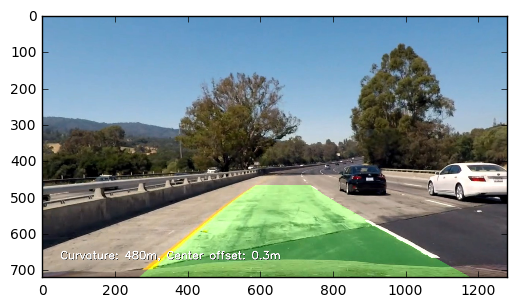

In [6]:
from collections import deque

# Detects lane pixels and draws them on a given image
def draw_lane(image, left_line_points = None, right_line_points = None, fail_count = 0, curvature_queue = deque([])):  
    image_height = image.shape[0]
    
    # Undistort given image
    undistorted_image = undistort(image)
    
    # Obtain binary image
    combined = get_binary_image(undistorted_image)
    
    # Change perspective for a given image
    warped = change_perspective(combined)
    
    # Find lane coordinates for a given perspective changed image
    left_lane_coordinates, right_lane_coordinates, fail_count = \
        get_lane_points(warped, left_line_points, right_line_points, fail_count)
    
    if len(left_lane_coordinates[1]) == 0 or len(right_lane_coordinates[1]) == 0:
        return undistorted_image, left_line_points, right_line_points, fail_count + 1, curvature_queue
        
    # Obtain polynomial lane fits
    left_fit, _ = fit_line(left_lane_coordinates[1], left_lane_coordinates[0])
    right_fit, _ = fit_line(right_lane_coordinates[1], right_lane_coordinates[0])
    
    y_vals = np.arange(0, image_height)

    left_fitx = get_x_for_line(left_fit, y_vals)
    right_fitx = get_x_for_line(right_fit, y_vals)

    # Create an image to draw the lines on
    color_warp = np.zeros_like(undistorted_image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_vals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = change_perspective(color_warp, reverse = True)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, .3, 0)
    
    # Obtain distance from center and curvature radius
    curverad, distance_from_center = \
    get_curvature_and_distance_from_center(left_lane_coordinates, \
                                           right_lane_coordinates, \
                                           image_width, \
                                           image_height)
    
    if len(curvature_queue) > 10:
        curvature_queue.popleft()
    
    curvature_queue.append(curverad)
    
    curverad_avarage = np.mean(curvature_queue)
    
    # Print curvature and center offset on an image
    stats_text = 'Curvature: {0:.0f}m, Center offset: {1:.1f}m'.format(curverad_avarage, \
                                                                distance_from_center)
    text_offset = 50
    text_shift = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, stats_text, \
                (text_offset + text_shift, image_height - text_offset + text_shift), \
                font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(result, stats_text, (text_offset, image_height - text_offset), \
                font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return result, \
            [y_vals.tolist(), left_fitx.tolist()], \
            [y_vals.tolist(), right_fitx.tolist()], \
            fail_count, \
            curvature_queue

# Obtain a test image
raw_test_image = mpimg.imread('../CarND-Advanced-Lane-Lines/binarize_test/test3.jpg')

# Draw lanes on a test image
result, _, _, _, _ = draw_lane(raw_test_image)

# Output a test image
plt.imshow(result)

# Video

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Converts a clip from raw file to a file with lane overlay
def write_clip(input_file, output_file, function):
    clip = VideoFileClip(input_file)
    
    global left_line_points, right_line_points, fail_count, curvature_queue
    left_line_points = None
    right_line_points = None
    fail_count = 0
    curvature_queue = deque([])
    
    white_clip = clip.fl_image(function) #NOTE: this function expects color images!
    %time white_clip.write_videofile(output_file, audio=False)  

# Function processes one frame of a video by drawing lanes on top of an image, and printing curvature & center offset
def process_frame(image):
    global left_line_points, right_line_points, fail_count, curvature_queue
    result, left_line_points, right_line_points, fail_count, curvature_queue = draw_lane(image, \
                                                                                        left_line_points, \
                                                                                        right_line_points, \
                                                                                        fail_count,
                                                                                        curvature_queue)
    return result

In [8]:
video_input1 = '../CarND-Advanced-Lane-Lines/project_video.mp4'
video_output1 = 'project_video_solution.mp4'

write_clip(video_input1, video_output1, process_frame)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [04:00<00:00,  5.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 6min 13s, sys: 56.2 s, total: 7min 10s
Wall time: 4min 1s


In [ ]:
video_input2 = '../CarND-Advanced-Lane-Lines/challenge_video.mp4'
video_output2 = 'challenge_video_solution.mp4'

write_clip(video_input2, video_output2, process_frame)

[MoviePy] >>>> Building video challenge_video_solution.mp4
[MoviePy] Writing video challenge_video_solution.mp4


100%|██████████| 485/485 [01:12<00:00,  6.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_solution.mp4 

CPU times: user 2min 9s, sys: 14.7 s, total: 2min 24s
Wall time: 1min 14s


In [ ]:
video_input3 = '../CarND-Advanced-Lane-Lines/harder_challenge_video.mp4'
video_output3 = 'harder_challenge_video_solution.mp4'

write_clip(video_input3, video_output3, process_frame)

[MoviePy] >>>> Building video harder_challenge_video_solution.mp4
[MoviePy] Writing video harder_challenge_video_solution.mp4


  8%|▊         | 91/1200 [00:17<03:16,  5.64it/s]